In [1]:
import os

while "src" not in os.listdir():
    assert "/" != os.getcwd(), "src directory not found"
    os.chdir("..")

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F


from src.lib.nyu_dataset import NYUDataset, transform
from src.lib.depth_estimator import DepthEstimator
from src.lib.resnet_loader import load_classifier_resnet50, load_contrastive_resnet50

In [2]:
DATA_DIR = "data"
DATASET_FILE = "nyu_depth_v2_labeled.mat"

batch_size = 64
lr = 0.0001
epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = NYUDataset(os.path.join(DATA_DIR, DATASET_FILE), transform=transform)

n_train, n_val = int(0.8 * len(dataset)), int(0.1 * len(dataset))
n_test = len(dataset) - n_train - n_val

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

print(n_train, n_val, n_test)

1159 144 146


In [4]:
classification = False
probing = True

if classification:
    model = DepthEstimator(load_classifier_resnet50(), probing=probing).to(device)
else:
    model = DepthEstimator(load_contrastive_resnet50("pretrained_models/resnet50_imagenet_bs2k_epochs600.pth.tar"), probing=probing).to(device)

IMAGENET_PATH = /home/aashukha/imagenet/raw-data/
======> Encoder: output dim 2048 | 25.557M parameters


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [6]:
validation_loss_history = []
loss_history = []

for epoch in range(epochs):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for i, (color_map, depth_map) in pbar:
        color_map = color_map.to(device)
        depth_map = depth_map.to(device)

        pred = model(color_map)
        loss = loss_fn(pred, depth_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # update pbar description with batch and loss
        pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Batch {i + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    # take tensors we don't need for validation off the gpu
    del color_map, depth_map, pred, loss
    torch.cuda.empty_cache()
    
    # compute validation loss
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (color_map, depth_map) in enumerate(val_loader):
            color_map = color_map.to(device)
            depth_map = depth_map.to(device)

            pred = model(color_map)
            val_loss += loss_fn(pred, depth_map).item()
        val_loss /= len(val_loader)

        validation_loss_history.append(val_loss)
    # display validation loss
    print(f"Epoch {epoch + 1}/{epochs} - Validation Loss: {val_loss:.4f}")

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/100 - Validation Loss: 0.4006


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/100 - Validation Loss: 0.2232


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/100 - Validation Loss: 0.2530


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/100 - Validation Loss: 0.2205


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/100 - Validation Loss: 0.1793


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/100 - Validation Loss: 0.1708


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/100 - Validation Loss: 0.1668


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/100 - Validation Loss: 0.1427


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/100 - Validation Loss: 0.1792


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/100 - Validation Loss: 0.1783


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/100 - Validation Loss: 0.1691


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12/100 - Validation Loss: 0.1518


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/100 - Validation Loss: 0.1321


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/100 - Validation Loss: 0.1625


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15/100 - Validation Loss: 0.1544


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/100 - Validation Loss: 0.1374


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17/100 - Validation Loss: 0.1372


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/100 - Validation Loss: 0.1601


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/100 - Validation Loss: 0.1272


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20/100 - Validation Loss: 0.1666


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21/100 - Validation Loss: 0.1405


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22/100 - Validation Loss: 0.1393


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 23/100 - Validation Loss: 0.1245


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24/100 - Validation Loss: 0.1444


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 25/100 - Validation Loss: 0.1149


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26/100 - Validation Loss: 0.1283


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27/100 - Validation Loss: 0.1409


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 28/100 - Validation Loss: 0.1150


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29/100 - Validation Loss: 0.1236


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 30/100 - Validation Loss: 0.1372


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 31/100 - Validation Loss: 0.1255


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 32/100 - Validation Loss: 0.1133


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 33/100 - Validation Loss: 0.1136


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 34/100 - Validation Loss: 0.1321


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 35/100 - Validation Loss: 0.1212


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 36/100 - Validation Loss: 0.1267


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 37/100 - Validation Loss: 0.1101


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 38/100 - Validation Loss: 0.1169


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 39/100 - Validation Loss: 0.1304


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 40/100 - Validation Loss: 0.1147


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 41/100 - Validation Loss: 0.1084


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 42/100 - Validation Loss: 0.1128


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 43/100 - Validation Loss: 0.1208


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 44/100 - Validation Loss: 0.1299


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 45/100 - Validation Loss: 0.1089


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 46/100 - Validation Loss: 0.1144


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 47/100 - Validation Loss: 0.1296


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 48/100 - Validation Loss: 0.1179


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 49/100 - Validation Loss: 0.1178


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 50/100 - Validation Loss: 0.1296


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 51/100 - Validation Loss: 0.1138


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 52/100 - Validation Loss: 0.1137


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 53/100 - Validation Loss: 0.1093


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 54/100 - Validation Loss: 0.1232


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 55/100 - Validation Loss: 0.1054


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 56/100 - Validation Loss: 0.1019


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 57/100 - Validation Loss: 0.1074


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 58/100 - Validation Loss: 0.1045


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 59/100 - Validation Loss: 0.1162


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 60/100 - Validation Loss: 0.1102


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 61/100 - Validation Loss: 0.1147


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 62/100 - Validation Loss: 0.1219


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 63/100 - Validation Loss: 0.0978


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 64/100 - Validation Loss: 0.1201


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 65/100 - Validation Loss: 0.1223


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 66/100 - Validation Loss: 0.1119


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 67/100 - Validation Loss: 0.1013


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 68/100 - Validation Loss: 0.0990


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 69/100 - Validation Loss: 0.1074


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 70/100 - Validation Loss: 0.1056


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 71/100 - Validation Loss: 0.1062


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 72/100 - Validation Loss: 0.1099


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 73/100 - Validation Loss: 0.1123


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 74/100 - Validation Loss: 0.1103


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 75/100 - Validation Loss: 0.0940


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 76/100 - Validation Loss: 0.1122


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 77/100 - Validation Loss: 0.1011


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 78/100 - Validation Loss: 0.1070


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 79/100 - Validation Loss: 0.1080


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 80/100 - Validation Loss: 0.1165


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 81/100 - Validation Loss: 0.1109


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 82/100 - Validation Loss: 0.1072


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 83/100 - Validation Loss: 0.1013


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 84/100 - Validation Loss: 0.1350


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 85/100 - Validation Loss: 0.1167


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 86/100 - Validation Loss: 0.0971


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 87/100 - Validation Loss: 0.1003


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 88/100 - Validation Loss: 0.0965


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 89/100 - Validation Loss: 0.1044


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 90/100 - Validation Loss: 0.1085


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 91/100 - Validation Loss: 0.1071


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 92/100 - Validation Loss: 0.0885


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 93/100 - Validation Loss: 0.1053


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 94/100 - Validation Loss: 0.1091


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 95/100 - Validation Loss: 0.1108


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 96/100 - Validation Loss: 0.1019


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 97/100 - Validation Loss: 0.1078


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 98/100 - Validation Loss: 0.1104


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 99/100 - Validation Loss: 0.1005


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 100/100 - Validation Loss: 0.0982


In [7]:
from datetime import datetime
import json

time_str = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
experiment_dir = os.path.join("experiments", time_str)
os.mkdir(experiment_dir)

# save model
with open(os.path.join(experiment_dir, "model.pth"), "wb") as f:
    torch.save(model, f)

config = {
    "classification": classification,
    "probing": probing,
    "batch_size": batch_size,
    "lr": lr,
    "epochs": epochs,
    "device": device.type,
    "experiment_dir": experiment_dir
}

# save config
with open(os.path.join(experiment_dir, "config.json"), "w") as f:
    json.dump(config, f)

histories = {
    "loss": loss_history,
    "val_loss": validation_loss_history
}

# save histories
with open(os.path.join(experiment_dir, "histories.json"), "w") as f:
    json.dump(histories, f)


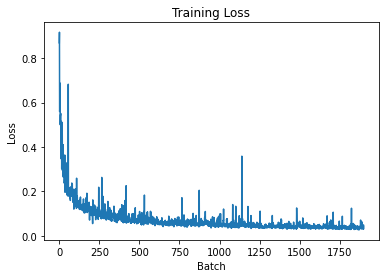

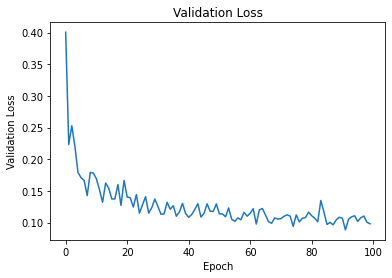

In [8]:
# Plot loss history
plt.plot(loss_history)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
# save figure
plt.savefig(os.path.join(experiment_dir, "training_loss_history.png"))
plt.show()

# Plot validation loss history
plt.plot(validation_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss")
# save figure
plt.savefig(os.path.join(experiment_dir, "validation_loss_history.png"))
plt.show()

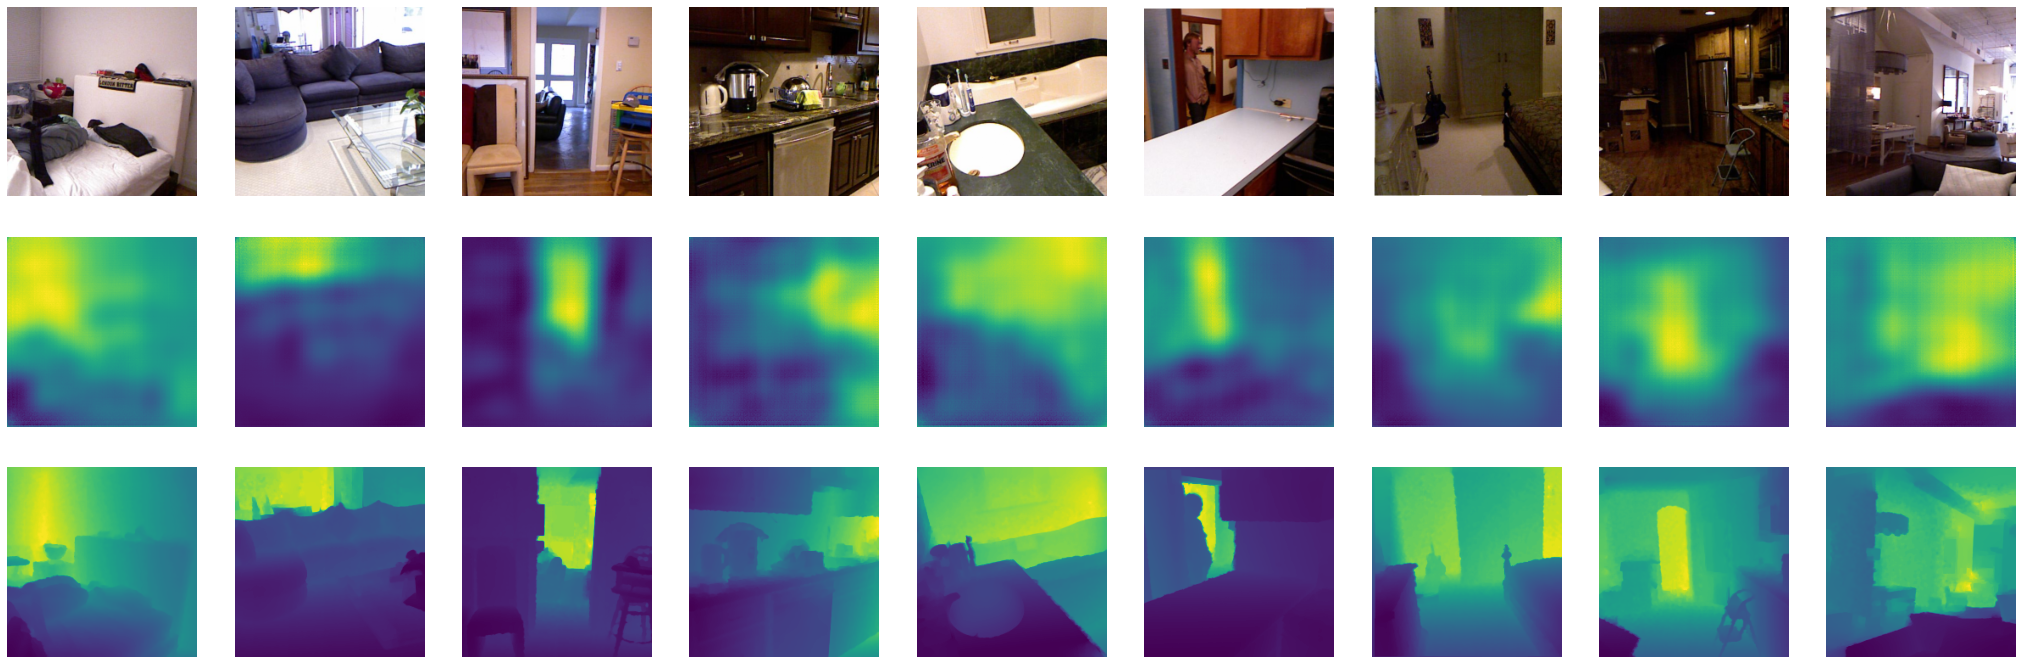

In [9]:
# Visualize the models predictions
# pick 9 random samples
idxs = np.random.choice(len(dataset), 9)
samples = [dataset[idx] for idx in idxs]
color_maps = []
depth_maps = []
preds = []
for color_tensor, depth_tensor in samples:
    # to numpy array
    color_map = color_tensor.cpu().numpy().transpose(1, 2, 0)
    depth_map = depth_tensor.cpu().numpy().squeeze()
    depth_prediction = model(color_tensor.unsqueeze(0).to(device)).cpu().detach().squeeze().numpy()

    color_maps.append(color_map)
    depth_maps.append(depth_map)
    preds.append(depth_prediction)

# plot 3x9 grid of color, depth, and prediction
fig, axes = plt.subplots(3, 9, figsize=(9*4, 3*4))
for i in range(9):
    axes[0, i].imshow(color_maps[i])
    depth_map = depth_maps[i]
    # scale between 0 and 1
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    pred = preds[i]
    # scale between 0 and 1
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    axes[2, i].imshow(depth_map)
    axes[1, i].imshow(pred)

for ax in axes.ravel():
    ax.axis("off")

# save figure
plt.savefig(os.path.join(experiment_dir, "predictions.png"))

plt.show()
